In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from dataset import QuickDrawDataset
from tqdm import tqdm

### Abstract
TODO

### Load Dataset

In [2]:
train_set = QuickDrawDataset(root="/data", train=True, download=False)
test_set = QuickDrawDataset(root="/data", train=False, download=False)

[quickdraw dataset: root=/data, train=True, download=False]
[quickdraw dataset: root=/data, train=False, download=False]


Split train dataset into train and validation

In [3]:
train_set, val_set = random_split(train_set, [31050, 3450])

In [4]:
batch_size = 128
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [5]:
for x, y in train_set:
    print(x.shape) # (N=1, H=28, W=28)
    break

torch.Size([1, 28, 28])


### Labels for Dataset

In [6]:
categories = QuickDrawDataset.categories()
num_categories = len(categories)
len(categories)

345

### Visualize Dataset
What does an airplane look like?

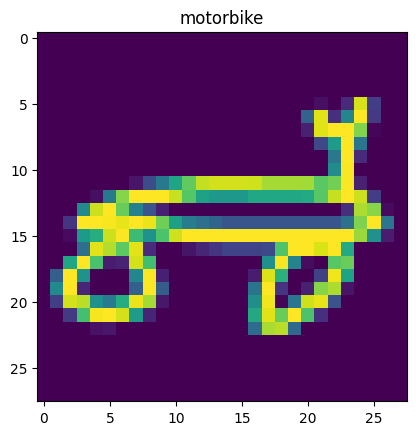

In [7]:
img, label = train_set[0]
category = categories[label]
plt.title(category)
plt.imshow(img[0])

### Define Model
MiniAlexNet: TODO

In [8]:
class MiniAlexNet(nn.Module):
    def __init__(self, labels=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, k=2, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            nn.Conv2d(96, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, k=2, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.nn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, labels),
        )

        self.init_bias()

    def init_bias(self):
        # with torch.no_grad():
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)

    def forward(self, x):
        x = self.conv(x)

#         print(x.shape)
        x = x.reshape(x.size(0), -1)

        # print(x.shape)
        x = self.nn(x)

        return x

In [36]:
class MiniAlexNet(nn.Module):
    def __init__(self, labels=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, k=2, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, k=2, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.nn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, labels),
        )

        self.init_bias()

    def init_bias(self):
        # with torch.no_grad():
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)

    def forward(self, x):
        x = self.conv(x)

#         print(x.shape)
        x = x.reshape(x.size(0), -1)

        # print(x.shape)
        x = self.nn(x)

        return x

In [37]:
minialexnet = MiniAlexNet(labels=num_categories)
minialexnet

MiniAlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (nn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
 

### Define Loss & Optimizer

In [38]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(minialexnet.parameters(), weight_decay=0.0005, momentum=0.9, lr=0.01)

### Train Model

In [39]:
num_train_batches = len(train_dataloader)
num_train_batches

243

In [40]:
def evaluate(model, dataloader, criterion):
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X)
            loss = criterion(pred, Y)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss    

In [41]:
epochs = 90
train_losses = []
val_losses = []

print("Training")
for epoch in range(epochs):
    # set mode to train
    minialexnet.train()
    
    total_loss = 0
    for i, (X, Y) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} of {epochs}", leave=True, position=0)):
        pred = minialexnet(X)
        loss = cross_entropy(pred, Y)
        
        total_loss += loss.item()
        
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # average loss over batches
    avg_loss = total_loss / len(train_dataloader)

    train_losses.append(avg_loss)
    
    # evaluate model on validation set
    val_loss = evaluate(minialexnet, dataloader=val_dataloader, criterion=cross_entropy)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss}, Val Loss: {val_loss}")

Training


Epoch 1 of 90: 100%|██████████████████████████| 243/243 [01:00<00:00,  3.99it/s]


Epoch [1/90], Loss: 5.8465422897181885, Val Loss: 5.844657191523799


Epoch 2 of 90: 100%|██████████████████████████| 243/243 [01:00<00:00,  3.99it/s]


Epoch [2/90], Loss: 5.844180256250954, Val Loss: 5.845337549845378


Epoch 3 of 90: 100%|██████████████████████████| 243/243 [01:00<00:00,  4.00it/s]


Epoch [3/90], Loss: 5.844049638190878, Val Loss: 5.845970665967023


Epoch 4 of 90: 100%|██████████████████████████| 243/243 [01:00<00:00,  4.01it/s]


Epoch [4/90], Loss: 5.843952216238642, Val Loss: 5.8465386143437135


Epoch 5 of 90: 100%|██████████████████████████| 243/243 [01:00<00:00,  4.01it/s]


Epoch [5/90], Loss: 5.843867998554873, Val Loss: 5.8470807252106844


Epoch 6 of 90: 100%|██████████████████████████| 243/243 [01:01<00:00,  3.97it/s]


Epoch [6/90], Loss: 5.843790548819083, Val Loss: 5.84753221935696


Epoch 7 of 90: 100%|██████████████████████████| 243/243 [01:01<00:00,  3.96it/s]


Epoch [7/90], Loss: 5.843773102073513, Val Loss: 5.847964339786106


Epoch 8 of 90: 100%|██████████████████████████| 243/243 [01:00<00:00,  4.00it/s]


Epoch [8/90], Loss: 5.843732802465619, Val Loss: 5.848342842525906


Epoch 9 of 90: 100%|██████████████████████████| 243/243 [01:01<00:00,  3.97it/s]


Epoch [9/90], Loss: 5.843666745802012, Val Loss: 5.848683887057835


Epoch 10 of 90: 100%|█████████████████████████| 243/243 [01:01<00:00,  3.98it/s]


Epoch [10/90], Loss: 5.843656174930525, Val Loss: 5.848933643764919


Epoch 11 of 90: 100%|█████████████████████████| 243/243 [01:01<00:00,  3.97it/s]


Epoch [11/90], Loss: 5.843612523726475, Val Loss: 5.849244347325078


Epoch 12 of 90: 100%|█████████████████████████| 243/243 [01:01<00:00,  3.96it/s]


Epoch [12/90], Loss: 5.8435887839077925, Val Loss: 5.849517204143383


Epoch 13 of 90: 100%|█████████████████████████| 243/243 [01:00<00:00,  4.01it/s]


Epoch [13/90], Loss: 5.843576802147759, Val Loss: 5.8497321517379195


Epoch 14 of 90: 100%|█████████████████████████| 243/243 [01:00<00:00,  4.00it/s]


Epoch [14/90], Loss: 5.843576174214053, Val Loss: 5.8499100473192005


Epoch 15 of 90:   5%|█▎                        | 12/243 [00:03<00:59,  3.90it/s]


KeyboardInterrupt: 

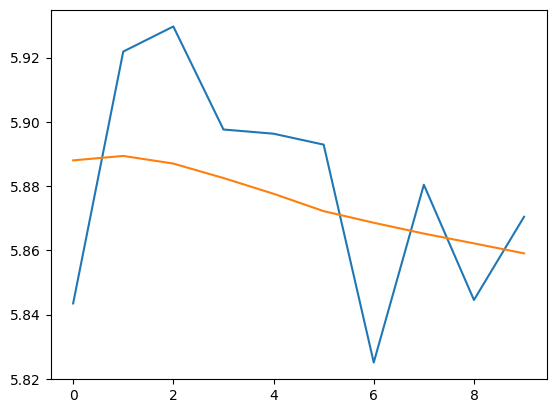

In [18]:
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), val_losses)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

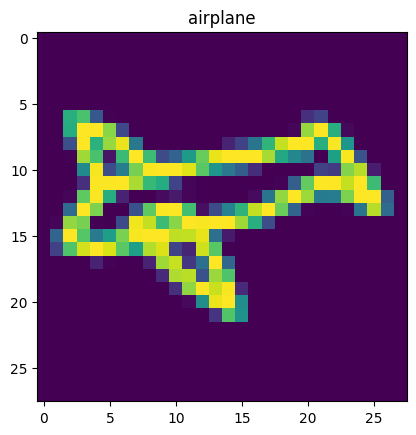

In [27]:
i = 101
img, label = train_set[i]
# print(img.shape)

plt.title(categories[label])
plt.imshow(img[0])

img = img.unsqueeze(0)

out = minialexnet(img)

print(out)

torch.argmax(out)

print(categories[label])

### Evaluate Model

In [8]:
print(torch.cuda.is_available())

False


In [10]:
torch.backends.mps.is_available()

True